# Oqtant Tutorial #

This tutorial will walk you through usage of Infleqtion's Oqtant API (aka OqtAPI).   

## Imports and user authentication ##

### Imports ###

In [15]:
import os
from oqtant.schemas.quantum_matter import QuantumMatterFactory
from oqtant.schemas.quantum_matter import QuantumMatter as qm
from oqtant.schemas.output import Gaussian_dist_2D
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import scipy.optimize as opt
from IPython.display import HTML

### Authenticate (manually) ###

Since summer school participants won't have Oqtant installed locally, we will use a hosted platform like binder instead.  This means we will authenticate using Oqtant's *manual* method:  

1. Navigate to [oqtant.infleqtion.com](https://oqtant.infleqtion.com) and create an account (if you haven't already)
2. Log in, if this is your first time you will need to activate your account with the verification email
2. On the left-hand menu selector, click on "Oqtant API" (or go to [oqtant.infleqtion.com/oqtantAPI](https://oqtant.infleqtion.com/oqtantAPI))
3. At the bottom of that page, click the box that copies your API access token to the clipboard
4. Paste that token just below and execute the cell (the if statement keeps the code from executing if you already authenticated above)

In [ ]:
qmf = QuantumMatterFactory()
qmf.login.access_token = "Paste your token here between the quotes!"
qmf.get_client()

## Making Quantum Matter ##


### Simple case using default settings ###

In [18]:
matter = qmf.create_quantum_matter(
    temperature=100,             # specify a final target temperature, in nK
    name="making quantum matter" # give your job an optional name
)

That's really all there is to do.  Before we submit the object to QMS, and create the associated *job*, we can inspect the potential energy landscape that the atoms will experience.  In this case, the atoms sit in a simple quadratic potential "bowl" formed by applied magnetic fields.  The geometry of this trap is the source of the "cigar" or "sausage" shape to our BEC -- the trap has 2 tight (high trapping frequency) axes and one loose (low trapping frequency) axis.  The horizontal dimension in Oqtant's images corresponds to the long axis of the cloud.

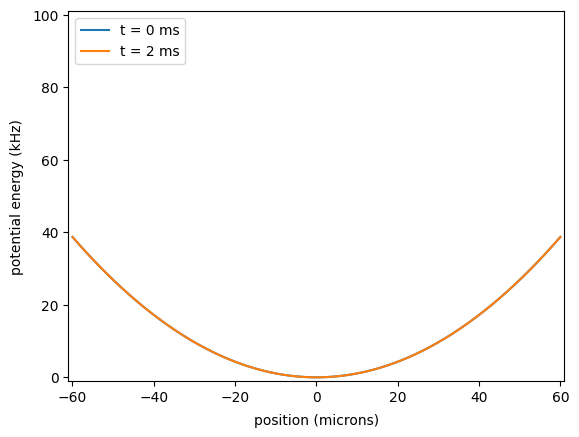

In [19]:
matter.show_potential(times=[0,2])

We already have all the inputs to submit our matter object to QMS.  We do that as follows, with the option to track the job status in real time.  Note, however, that further notebook cell execution will not be possible until the job completes and the tracking procedure terminates.

In [20]:
matter.submit(track=True)

Submitting 1 job(s):

- Job: making quantum matter
  Job ID: 1c1b30b7-6624-4b8b-983c-1533dddeece1

Tracking 1 job(s):

- Job: making quantum matter
  - RUNNING
  - COMPLETE

All job(s) complete


Once complete, we can fetch the results of the experimental run

In [21]:
matter.get_result()

The *output* of our job includes a number of calculated quantities and an image of our atom cloud.  In the case of using the defaults (since we haven't specified anything different), this example will be a so-called "time of flight" image where the atom cloud has been allowed to fall under gravity away from the chip before the image is taken.  How the cloud evolves in shape, size, and aspect ratio, is a result of the in-trap phase-space density and cloud temperature.  Strikingly, highly condensed clouds (highly "quantum" matter) exhibit inversion of the cloud aspect ratio during free fall.  

The set of available output fields can be revealed as follows:

In [22]:
results = matter.output
results.fields

- mot_fluorescence_image
  - pixels
  - rows
  - columns
  - pixcal
- tof_image
  - pixels
  - rows
  - columns
  - pixcal
- tof_fit_image
  - pixels
  - rows
  - columns
  - pixcal
- tof_fit
  - gaussian_od
  - gaussian_sigma_x
  - gaussian_sigma_y
  - tf_od
  - tf_x
  - tf_y
  - x_0
  - y_0
  - offset
- tof_x_slice
  - points
- tof_y_slice
  - points
- total_mot_atom_number
- tof_atom_number
- thermal_atom_number
- condensed_atom_number
- temperature_nk


Of particular interest is the image taken of our cloud after the user-specified time of flight.  Built-in helper functions make visualizing these data quick and easy:

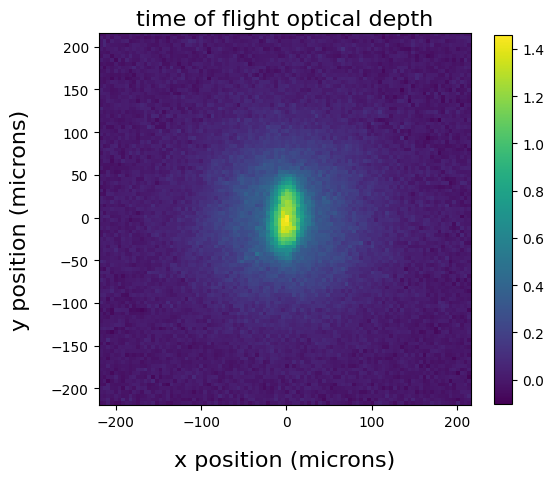

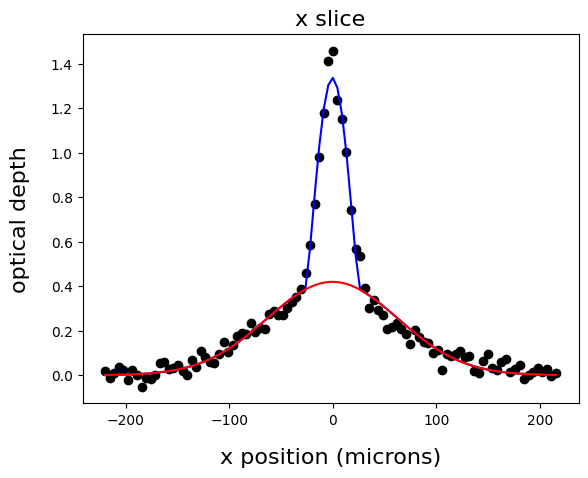

In [23]:
results.plot_tof(figsize=(6, 6))
results.plot_slice(axis="x")

In the slice, the bimodal distribution is evident; the atom cloud is composed of a thermal (~Gaussian) component and a condensed Thomas-Fermi component.

If you want to get serious, you'll be spending a lot of time analyzing TOF images.  They reveal the instantaneous macroscopic wavefunction and how it evolves over time, allow you to evaluate the thermal and condensed fractions and populations for different evaporation conditions, observe interference of falling clouds, and much more. In certain cases, some basic analysis is done for you, e.g. 

In [24]:
print("temperature (nK):", results.temperature_nk)
print("thermal atom population:", results.thermal_atom_number)
print("condensed atom population:", results.condensed_atom_number)

temperature (nK): 153
thermal atom population: 38065
condensed atom population: 6452


### Simulating your quantum matter ###

A user can toggle whether a job is submitted to the Oqtant cloud service, or a simulator that runs locally on their machine.  The simulator option is selected by passing the *sim=True* flag to the submit() function.  Note, the simulator solves the Gross-Pitaevskii equation that only takes into account the condensed fraction of the cloud.  You are free to use the simulator at any time, while your experimental jobs that target hardware hosted at Infleqtion will only run when the machine is accepting and executing cloud jobs. 

In [25]:
matter = qmf.create_quantum_matter(temperature=100, name="making quantum matter")
matter.submit(sim=True)

submitted simulation


Somewhat strangely (and this is likely to change), the simulation doesn't actually run until you try to grab the results.  You'll find the simulation is not particularly speedy on nanohub's hardware.

In [26]:
matter.get_result()

ground state calculation in progress       
ground state calculation complete          
trapped simulation in progress             
trapped simulation complete                    
time-of-flight simulation in progress              
Simulation complete.d TOF  21.890 of 22.000ms          


### Customizing the evaporation and experiment ###

So far, we haven't done anything except use built-in defaults (other than specify the target cloud temperature).  Additional parameters/arguments can be passed to give more control:

In [28]:
matter = qmf.create_quantum_matter(
    temperature=100,  # target cloud temperature
    lifetime=10,      # hold atoms for this many ms before releasing from chip
    time_of_flight=8, # drop atoms for this many ms before taking image
    name="QM w/ more control",
    note="Something I wanted to remember about this run" # user note
)

Job names and notes can be used for searching for particular data/runs in the future.

Oqtant also gives the user more fine grained control of the forced evaporation process.  Changing the details of this RF sweep results in different atom populations, final temperature, condensed/thermal fractions, etc.  Fine control is possible by defining ordered pairs of time / frequency / power for the forced RF evaporation process through the use of an RfEvap object:

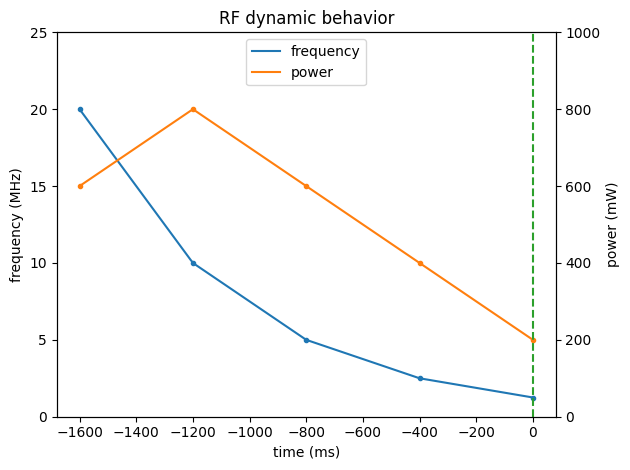

In [29]:
evap = qmf.create_rf_evap(
    times=[0, 400, 800, 1200, 1600],    # evaporation times (in ms)
    powers=[600, 800, 600, 400, 200],   # evaporation powers (in mW)
    frequencies=[20, 10, 5, 2.5, 1.25], # evaporation frequencies (in MHz)
    interpolation="LINEAR",             # how to connect the point in time
)

matter = qmf.create_quantum_matter(
    rf_evap=evap, 
    name="making quantum matter with direct rf control"
)
matter.show_rf_dynamics()

### In-trap imaging ###

So far, we have taken the final image of our atom cloud after it has been released from the chip.  You can also take the picture while atoms are still held under the chip in the magnetic trap.  This is especially useful to study in-trap dynamics (e.g. tunneling through a barrier, which we will discuss next) that might be harder to observe if the atom cloud is allowed to fall.

In [30]:
matter = qmf.create_quantum_matter(
    temperature=100,  # target cloud temperature
    lifetime=10,      # hold atoms for this many ms before releasing from chip
    image="IN_TRAP",  # specify image should be taken 
    name="QM imaged in trap",
    note="Oh yeah, you can image in trap too!" # user note
)

In [31]:
matter.submit(track=True)

Submitting 1 job(s):

- Job: QM imaged in trap
  Job ID: 9bc01ff8-0e1b-41a7-a92e-4adb510c4cca

Tracking 1 job(s):

- Job: QM imaged in trap
  - RUNNING
  - COMPLETE

All job(s) complete


- it_plot
  - pixels
  - rows
  - columns
  - pixcal


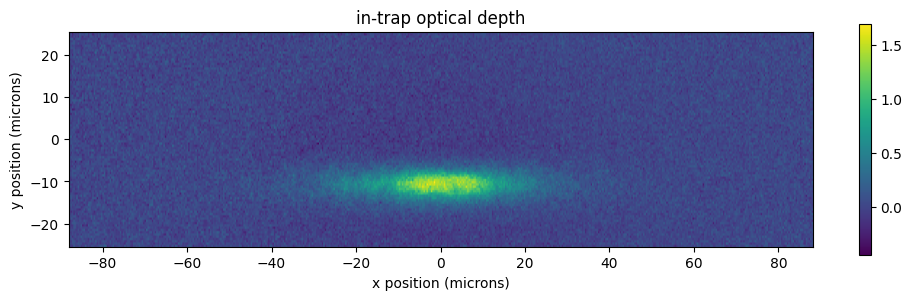

In [34]:
matter.output.fields
matter.output.plot_it()

## Manipulating Quantum Matter ##

So far, we've only explored the ability to make quantum matter, and then specify what type of image we are interested in taking at the end.  Now comes the fun part, where we explore how to manipulate the quantum matter that we have created.  In Oqtant's current form, this is done by giving the user control over the application of blue-detuned "painted light" on the atom cloud.  Because the light is blue detuned, it represents a repulsive potential energy for the atoms.  Controlling where the light is projected, and the intensity as a function of position, allows us to manipulate the potential energy surface that the atoms explore.  Currently, painted potential capabilities are restricted to by "one dimensional" where positions are specified along the long axis of the cloud. The simplest object that we can create is appropriately called a "Barrier".  We can dynamically control the position, energetic height, width, and shape...

### Making a static Barrier ###

Let's start by demonstrating how to make a static barrier, with fixed position, width, and height.  It will be created at t=2.5 ms and destroyed at t=7.5 ms

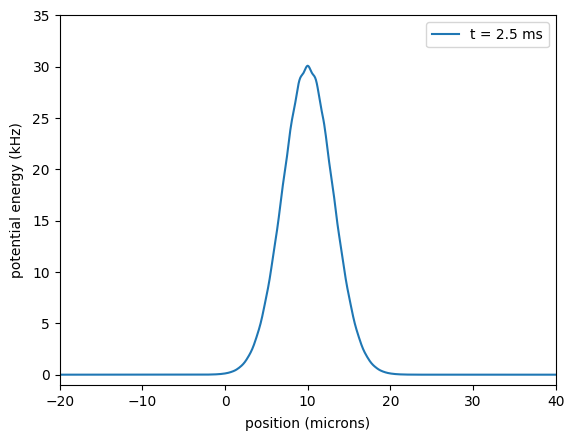

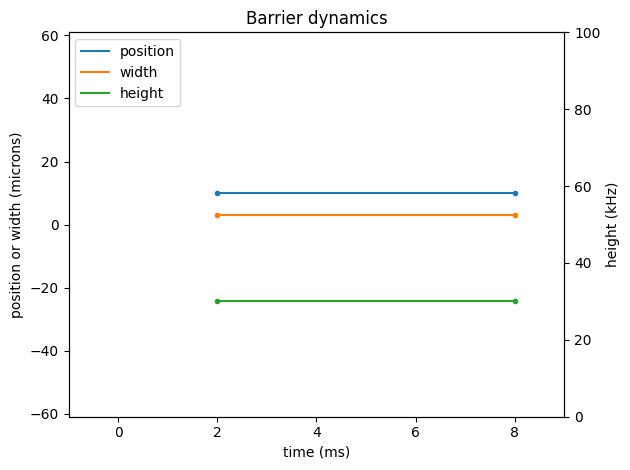

In [35]:
barrier = qmf.create_barrier(
    times=[2, 8],   # times (in ms) at which we will define barrier characteristics
    positions=[10, 10], # center positions of the barrier at those times
    heights=[30, 30],   # energetic height (in kHz) at those times
    widths=[3, 3],      # barrier widths (in um) at those times
    shape="GAUSSIAN",   # barrier shape; "GAUSSIAN" or "LORENTZIAN" or "SQUARE"
)

barrier.show_potential(times=[2.5], ylimits=[-1,35], xlimits=[-20, 40])
barrier.show_dynamics()

The eagle-eyed among you might notice that the barrier shape is not exactly Gaussian, as requested.  This is because Oqtant knows about the hardware limitations inherent to the optical projection system, which has finite resolution etc.  

### Applying that barrier to your quantum matter ###

Including that barrier in your experiment is simple, just add one or more barriers to your QuantumMatter object before submission:

In [36]:
matter = qmf.create_quantum_matter(
    temperature=100,
    lifetime=barrier.death, # end experiment when barrier is destroyed
    image="IN_TRAP",        # barrier effects most obvious in trap
    barriers=[barrier],     # include one or more barriers
    name="Now with a barrier!",
)

In [37]:
matter.submit(track=True)

Submitting 1 job(s):

- Job: Now with a barrier!
  Job ID: 6a56aa03-d113-4989-9d3b-1a004746f985

Tracking 1 job(s):

- Job: Now with a barrier!
  - RUNNING
  - COMPLETE

All job(s) complete


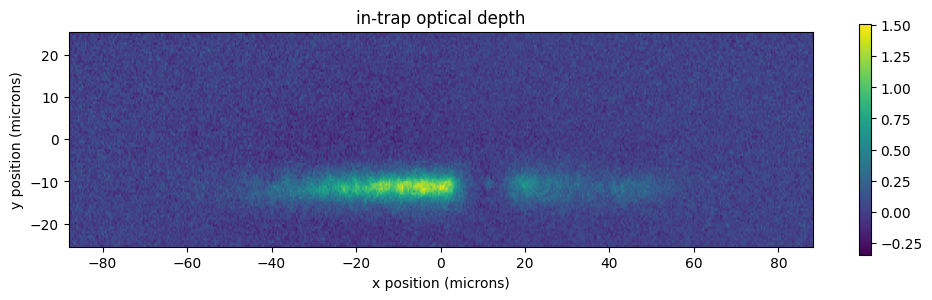

In [38]:
matter.get_result()
matter.output.plot_it()

### Scripting Barrier behavior ###

Instead of entering lists in the instantiation of the barrier, you can also script its behavior:

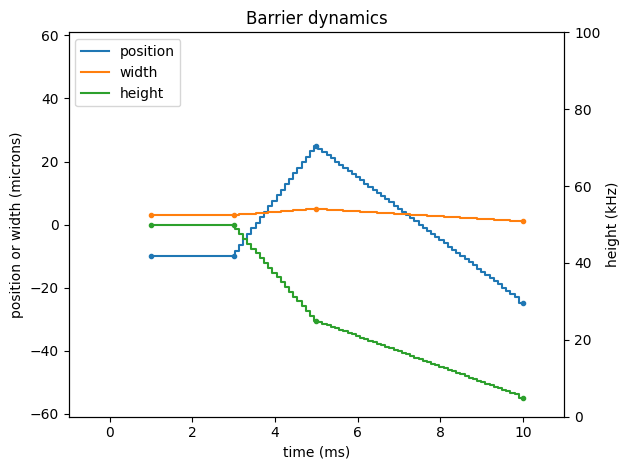

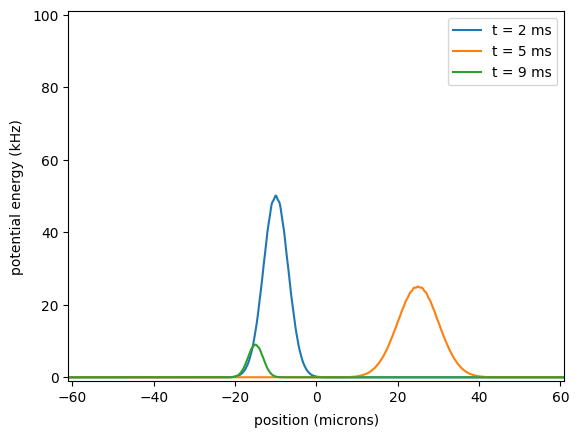

In [39]:
# start with a static barrier held on for some time
barrier = qmf.create_barrier(
    positions=[-10, -10],
    heights=[50, 50],
    widths=[3, 3],
    times=[1, 3],
    shape="GAUSSIAN",
)

# add dynamics, automatically increasing the barrier lifetime
barrier.evolve(duration=2, position=25, height=25, width=5)

# and more dynamics after that
barrier.evolve(duration=5, position=-25, height=5, width=1)

# show the barrier at the following times, along with the overall dynamics
barrier.show_dynamics()
barrier.show_potential(times=[2, 5, 9])

### Visualizing the total potential energy ###

Your QuantumMatter object knows about its constituent barrier(s):

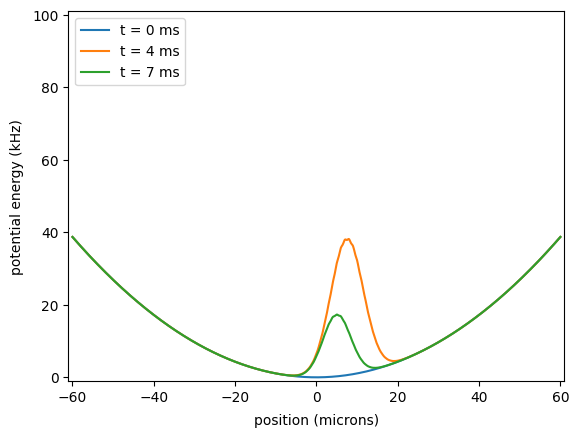

In [40]:
matter = qmf.create_quantum_matter(
    temperature=100,
    lifetime=barrier.death, # end experiment when barrier is destroyed
    image="IN_TRAP",        # barrier effects most obvious in trap
    barriers=[barrier],     # include one or more barriers
    name="Now with a barrier!",
)
matter.show_potential(times=[0, 4, 7])

## Landscapes ##

Another useful abstraction is that of a 'Landscape', which represents the dynamic potential energy as a function of position.  A landscape is composed of instantaneous 'Snapshot' objects, which represent the applied optical potential energy at a specific time.  

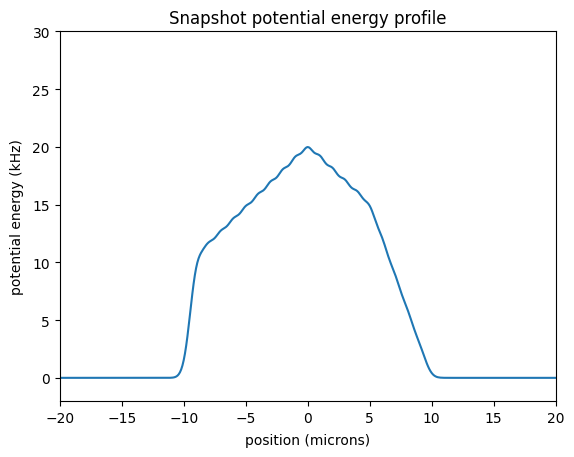

In [41]:
snapshot = qmf.create_snapshot(
    time=2,
    positions=[-10, -9.5, 0, 5, 10],
    potentials=[0, 10, 20, 15, 0],
    interpolation="LINEAR",
)

snapshot.show_potential(xlimits=[-20, 20], ylimits=[-2, 30])

For a snapshot, the interpolation option chosen tells Oqtant how to connect the points in space:

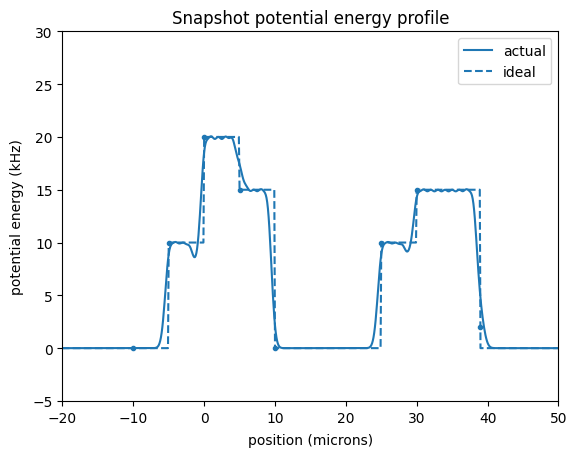

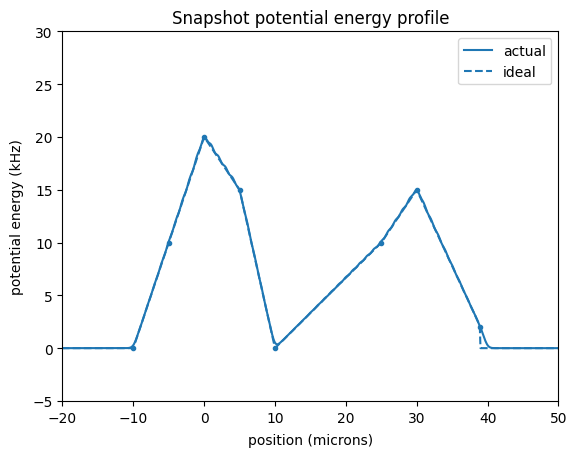

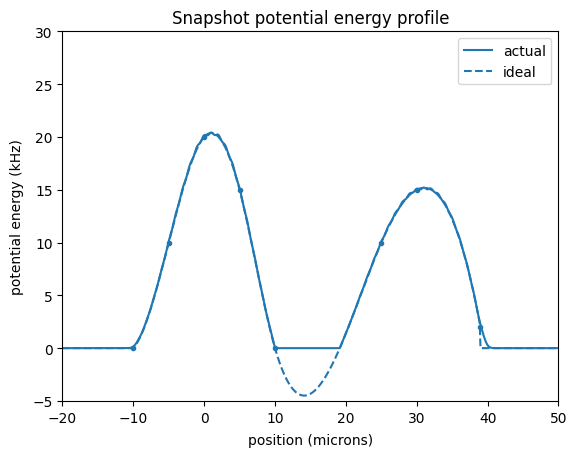

In [42]:
options = ["OFF", "LINEAR", "CUBIC"]
for option in options:
    snapshot = qmf.create_snapshot(
        time=2,
        positions=[-10, -5, 0, 5, 10, 25, 30, 39],
        potentials=[0, 10, 20, 15, 0, 10, 15, 2],
        interpolation=option,
    )
    snapshot.show_potential(ylimits=[-5, 30], xlimits=[-20, 50], include_ideal=True)

We create landscapes by using 2 or more snapshots to create them.  Oqtant will linearly interpolate between the given snapshots to determine the instantaneous landscape potential energy as a function of position.

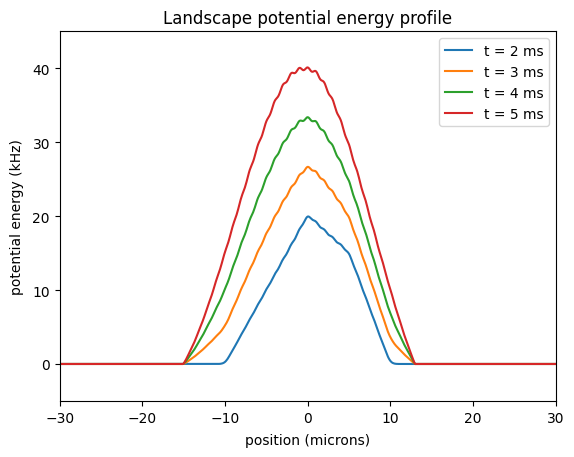

In [43]:
snapshot1 = qmf.create_snapshot(
    time=2,
    positions=[-10, -5, 0, 5, 10],
    potentials=[0, 10, 20, 15, 0],
    interpolation="LINEAR",
)

snapshot2 = qmf.create_snapshot(
    time=5,
    positions=[-20, -10, 0, 10, 20],
    potentials=[0, 15, 40, 10, 0],
    interpolation="CUBIC",
)

landscape = qmf.create_landscape(snapshots=[snapshot2, snapshot1])

landscape.show_potential(times=[2, 3, 4, 5], xlimits=[-30, 30], ylimits=[-5, 45])

### Adding a Landscape to your QuantumMatter ###

Adding a Landscape potential to your quantum matter experiment is similar to how you add a barrier, except there is only one (instead of a list).  Simultaneous usage of barriers and landscapes is supported.

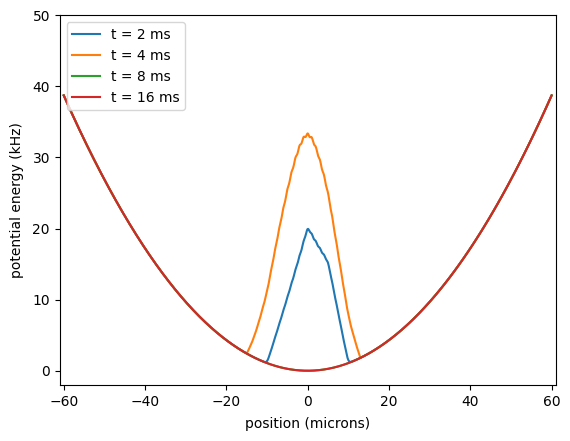

In [44]:
matter = qmf.create_quantum_matter(
    name="now with landscapes!",
    temperature=100,
    lifetime=20,
    time_of_flight=10,
    landscape=landscape,
)

matter.show_potential(times=[2, 4, 8, 16], ylimits=[-2, 50])

## Multi-slit diffraction ##

Let's perform a fun little experiment using landscapes to split our (coherent!) atom cloud into multiple pieces and then letting those pieces recombine and interfere.  This is the basis of atom interferometry and quantum sensing.

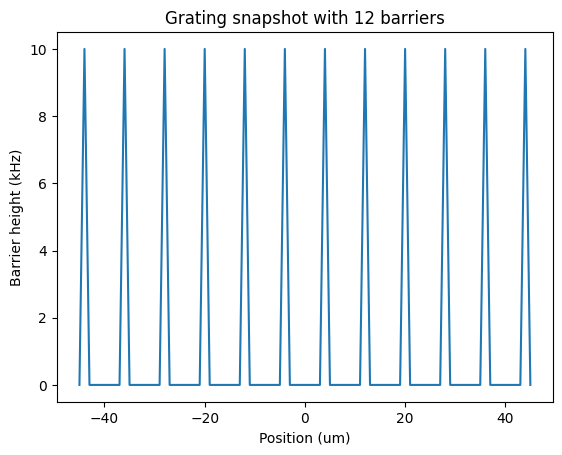

In [45]:
n_barriers = 12  # number of barrier peaks
potential_height = 10  # height of the barrier potentials (kHz)
landscape_width = 90  # the total landscape size we're projecting over (um)
T = 50  # target temperature of the atoms (nK)

positions = np.arange(
    -(landscape_width / 2), (landscape_width / 2) + 1, 1
)  # setting up the spatial array of points centered around the grid size above
barrier_positions = np.linspace(
    -(landscape_width / 2) + 1, (landscape_width / 2) - 1, n_barriers
)
periodic_potential = potential_height * np.in1d(positions, np.round(barrier_positions))

plt.figure()
plt.plot(positions, periodic_potential)
plt.xlabel("Position (um)")
plt.ylabel("Barrier height (kHz)")
plt.title("Grating snapshot with " + str(n_barriers) + " barriers")
plt.show()

### Create a landscape that splits the cloud into multiple components ###

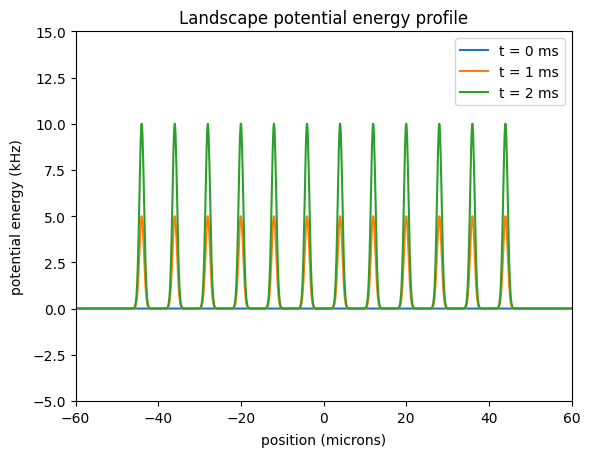

In [46]:
time_evolve = 2  # end time for periodic snapshot

snapshot_zero = qmf.create_snapshot(
    time=0,
    positions=positions,
    potentials=np.zeros_like(positions),
    interpolation="OFF",
)

snapshot_periodic = qmf.create_snapshot(
    time=time_evolve,
    positions=positions,
    potentials=periodic_potential,
    interpolation="LINEAR",
)

# create the total landscape
landscape_periodic = qmf.create_landscape(snapshots=[snapshot_zero, snapshot_periodic])

landscape_periodic.show_potential(times=[0, 1, 2], xlimits=[-60, 60], ylimits=[-5, 15])

### Create jobs with various time of flights ###

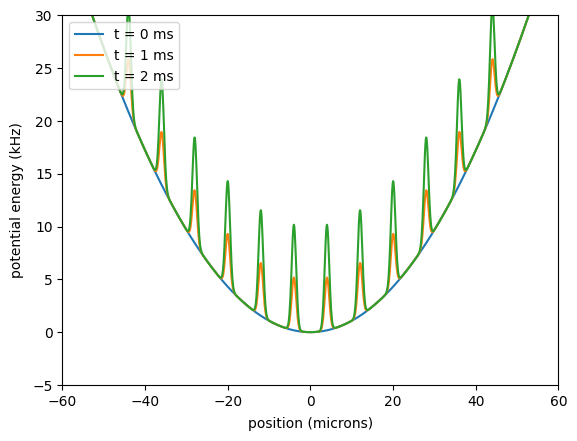

In [47]:
tofs = [5, 10, 15, 20]
matters_tof = []

for tof in tofs:
    matters_tof.append(
        qmf.create_quantum_matter(
            temperature=T,
            lifetime=time_evolve,
            landscape=landscape_periodic,
            time_of_flight=tof,
            name="Many BEC interference, tof = " + str(tof) + " ms",
        )
    )
    
matters_tof[0].show_potential(times=[0, 1, 2], xlimits=[-60, 60], ylimits=[-5, 30])

### Submit! ###

In [48]:
[matter.submit(track=True) for matter in matters_tof]
id_list = [matter.job_id for matter in matters_tof]

Submitting 1 job(s):

- Job: Many BEC interference, tof = 5 ms
  Job ID: cd68cbc2-608d-4e34-a04f-1387b36252fe

Tracking 1 job(s):

- Job: Many BEC interference, tof = 5 ms
  - RUNNING
  - COMPLETE

All job(s) complete
Submitting 1 job(s):

- Job: Many BEC interference, tof = 10 ms
  Job ID: aa5343da-3961-4335-bb42-72eb07249517

Tracking 1 job(s):

- Job: Many BEC interference, tof = 10 ms
  - RUNNING
  - COMPLETE

All job(s) complete
Submitting 1 job(s):

- Job: Many BEC interference, tof = 15 ms
  Job ID: f2040460-e50c-488a-b8b5-124788fa8174

Tracking 1 job(s):

- Job: Many BEC interference, tof = 15 ms
  - RUNNING
  - COMPLETE

All job(s) complete
Submitting 1 job(s):

- Job: Many BEC interference, tof = 20 ms
  Job ID: 531f8e01-6964-4395-ae20-6f77ffcadbbb

Tracking 1 job(s):

- Job: Many BEC interference, tof = 20 ms
  - RUNNING
  - COMPLETE

All job(s) complete


### Retrieve the results ###

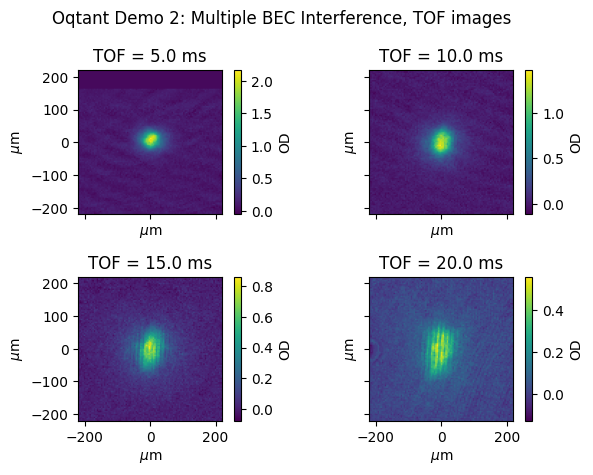

In [49]:
for matter in matters_tof:
    matter.get_result()

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
ax_flat = axes.flatten()

for i in range(len(matters_tof)):
    pixcal = matters_tof[i].output.get_image_pixcal(image="TIME_OF_FLIGHT")
    tof_image = matters_tof[i].output.get_image_data(image="TIME_OF_FLIGHT")
    ax = ax_flat[i]
    im = ax.imshow(
        tof_image, extent=[-50 * pixcal, 50 * pixcal, -50 * pixcal, 50 * pixcal]
    )
    ax.set_title("TOF = " + str(matters_tof[i].time_of_flight) + " ms")
    ax.set_xlabel("$\mu$m")
    ax.set_ylabel("$\mu$m")
    fig.colorbar(im, ax=ax, label="OD")

fig.suptitle("Oqtant Demo 2: Multiple BEC Interference, TOF images")
fig.tight_layout()
plt.show()

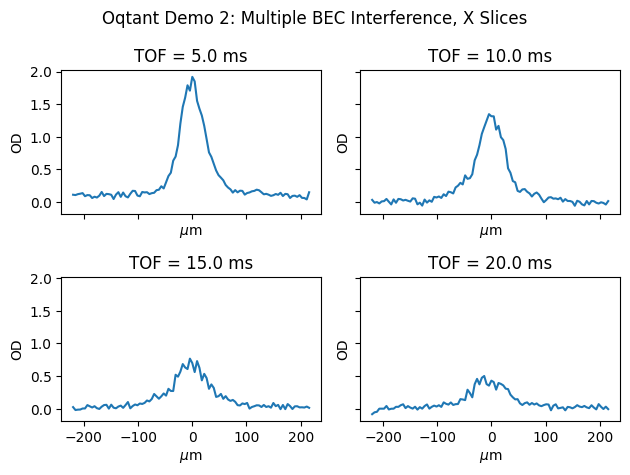

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
ax_flat = axes.flatten()

for i in range(len(matters_tof)):
    ax_flat[i].plot(
        np.arange(-50, 50) * pixcal, np.array(matters_tof[i].output.get_slice(axis="x"))
    )
    ax_flat[i].set_title("TOF = " + str(matters_tof[i].time_of_flight) + " ms")
    ax_flat[i].set_ylabel("OD")
    ax_flat[i].set_xlabel("$\mu$m")

fig.suptitle("Oqtant Demo 2: Multiple BEC Interference, X Slices")
fig.tight_layout()
plt.show()

This fun little example illustrates the wavelike nature and coherent properties of quantum matter.  Oqtant lets you explore the very basics of phenomena behind quantum sensing and related quantum technologies.